In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearson3

In [2]:
def retrieve_retro_data(
    feature_id: int,
    odir: Path = Path("NWM_data"),
    url: str = "s3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr"
) -> pd.Series:
    """This function retrieves NWM retrospective data from AWS
    and returns a pandas.Series of streamflow data for a single
    channel feature.
    """
    # Check local file
    ofile = odir / f"NWM_{feature_id}.nc"
    if ofile.exists():
        return xr.open_dataarray(ofile).to_dataframe()["streamflow"]

    # Get xarray.dataset
    # Requires s3fs and zarr be installed
    ds = xr.open_dataset(
        url,
        backend_kwargs={
            "storage_options": {"anon": True},
            "consolidated": True
        },
        engine="zarr"
    )

    # Extract time series data
    da = ds.streamflow.sel(feature_id=feature_id)

    # Save
    odir.mkdir(exist_ok=True, parents=True)
    da.to_netcdf(ofile)

    # Return Series
    return da.to_dataframe()["streamflow"]

In [3]:
# Load data as pandas.Series
streamflow = retrieve_retro_data(23606454)

In [4]:
# Result is pandas.Series of streamflow data with a DateTimeIndex in m^3/s
streamflow.head()

time
1979-02-01 01:00:00    0.02
1979-02-01 02:00:00    0.02
1979-02-01 03:00:00    0.02
1979-02-01 04:00:00    0.02
1979-02-01 05:00:00    0.02
Name: streamflow, dtype: float64

In [5]:
# Look at data limits
streamflow.index.min(), streamflow.index.max()

(Timestamp('1979-02-01 01:00:00'), Timestamp('2023-02-01 00:00:00'))

In [6]:
# Trim to whole water-years (Oct 1 - Sep 30)
# Note padding of 6 days so every water year
# will have the same number of 7-day averages
start = pd.Timestamp("1979-10-01T00:00") - pd.Timedelta("6d")
end = pd.Timestamp("2022-09-30T23:00")
streamflow_trimmed = streamflow[start:end]

In [7]:
# Now we compute the yearly peaks
streamflow_yearly_max = streamflow_trimmed.resample("1YE").max()

# Update the index
streamflow_yearly_max.index.name = "water_year"
streamflow_yearly_max.index = streamflow_yearly_max.index.year

In [8]:
streamflow_yearly_max.head()

water_year
1979     0.03
1980     5.14
1981     7.21
1982    18.20
1983     7.95
Name: streamflow, dtype: float64

In [9]:
# Now we compute the daily peaks
streamflow_daily_max = streamflow_trimmed.resample("1D").max()

# Update the index
streamflow_daily_max.index.name = "water_day"
streamflow_daily_max.index = streamflow_daily_max.index.date

In [10]:
streamflow_daily_max.head()

1979-09-25    0.03
1979-09-26    0.03
1979-09-27    0.03
1979-09-28    0.03
1979-09-29    0.03
Name: streamflow, dtype: float64

In [11]:
# Convert recurrence interval (RI) to quantile
recurrence_interval = 1.5
annual_exeedance_probability = 1.0 / recurrence_interval
quantile = 1.0 - annual_exeedance_probability
percentile = 100.0 * quantile
print(
    f"Recurrence Interval: {recurrence_interval} years\n",
    f"Annual Exceedance Probability: {annual_exeedance_probability*100.0:.2f} %\n",
    f"Quantile: {quantile:.2f}\n",
    f"Percentile: {percentile:.2f}-th\n"
)

Recurrence Interval: 1.5 years
 Annual Exceedance Probability: 66.67 %
 Quantile: 0.33
 Percentile: 33.33-th



In [12]:
# Convert recurrence interval (RI) to daily quantile
daily_recurrence_interval = recurrence_interval * 365.25
daily_exeedance_probability = 1.0 / daily_recurrence_interval
daily_quantile = 1.0 - daily_exeedance_probability
daily_percentile = 100.0 * daily_quantile
print(
    f"Recurrence Interval: {daily_recurrence_interval:.1f} days\n",
    f"Daily Exceedance Probability: {daily_exeedance_probability*100.0:.4f} %\n",
    f"Daily Quantile: {daily_quantile:.4f}\n",
    f"Daily Percentile: {daily_percentile:.2f}-th\n"
)

Recurrence Interval: 547.9 days
 Daily Exceedance Probability: 0.1825 %
 Daily Quantile: 0.9982
 Daily Percentile: 99.82-th



In [13]:
# Empirical exceedance (annual)
empirical_1_5RI = streamflow_yearly_max.quantile(quantile)
f"Empirical {recurrence_interval}Y RI flow rounded to model precision is {empirical_1_5RI:.2f} m^3/s"

'Empirical 1.5Y RI flow rounded to model precision is 5.17 m^3/s'

In [14]:
# Empirical exceedance (daily)
daily_empirical_1_5RI = streamflow_daily_max.quantile(daily_quantile)
f"Empirical {daily_recurrence_interval:.1f} day RI flow rounded to model precision is {daily_empirical_1_5RI:.2f} m^3/s"

'Empirical 547.9 day RI flow rounded to model precision is 28.53 m^3/s'

In [15]:
# Fitting to a distribution
streamflow_logs = np.log(streamflow_yearly_max)
pearson_params = pearson3.fit(streamflow_logs)
fitted_1_5RI = np.exp(pearson3.ppf(quantile, *pearson_params))
f"Fitted {recurrence_interval}Y RI flow rounded to model precision is {fitted_1_5RI:.2f} m^3/s"

'Fitted 1.5Y RI flow rounded to model precision is 3.36 m^3/s'

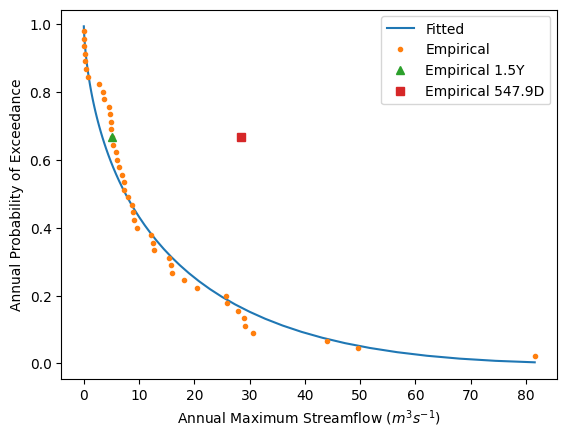

In [17]:
# Plot fit
x = np.linspace(streamflow_logs.min(), streamflow_logs.max(), 100)
y = 1.0 - pearson3.cdf(x, *pearson_params)
n = len(streamflow_yearly_max)
x_emp = np.round(streamflow_yearly_max.sort_values(), 2)
y_emp = 1.0 - ((np.arange(n) + 1.0) / (n + 1.0))
plt.plot(np.exp(x), y, label="Fitted")
plt.plot(x_emp, y_emp, ".", label="Empirical")
plt.plot([empirical_1_5RI], [annual_exeedance_probability], "^", label=f"Empirical {recurrence_interval}Y")
plt.plot([daily_empirical_1_5RI], [annual_exeedance_probability], "s", label=f"Empirical {daily_recurrence_interval:.1f}D")
plt.xlabel("Annual Maximum Streamflow ($m^3 s^{-1}$)")
plt.ylabel("Annual Probability of Exceedance")
plt.legend()
plt.show()